In [1]:
import sys
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from typing import List
import numpy as np
from tqdm.notebook import trange as trange
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

from utils.data_utils import *
from test_framework.model_interface import ModelInterface
from test_framework.tester import Tester
from test_framework.metrics import *
from active_learning.categorical_query_functions import *
from active_learning.gradient_embedding import compute_gradient_embeddings
from active_learning.cluster_margin import *

## Dataset and Model Constants

In [35]:
# Data Constants
DATA_DIR = "../data/kaggle_satellite_image_classification"
NUM_CLASSES = 4
MAIN_IMG_DIMS = (64, 64)
SECONDARY_IMG_DIMS = (32, 32)
MAX_SECONDARY_IMAGES = 5

# Model Constants
FINAL_LAYER_LEN = 64

# Training Constants
TEST_DATA_FRACTION = 0.05

## Load Dataset, creating secondary modality

0.22580774
Label = [0. 0. 1. 0.]


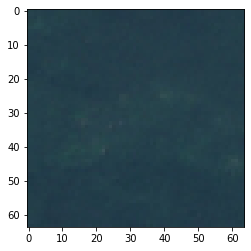

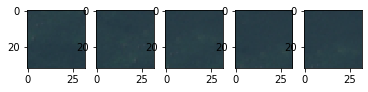

Label = [1. 0. 0. 0.]


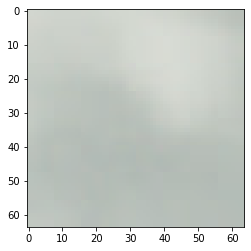

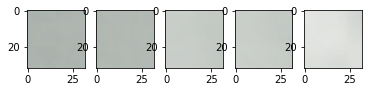

Label = [0. 1. 0. 0.]


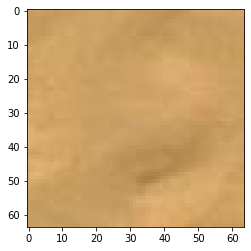

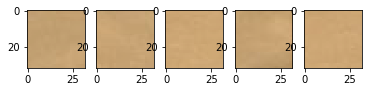

Label = [1. 0. 0. 0.]


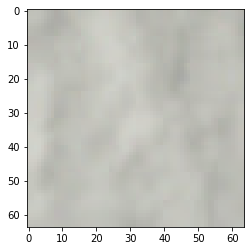

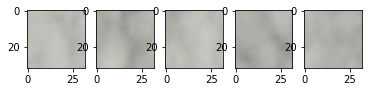

In [36]:
def load_dataset_as_numpy(max_samples: int = None):
    def transform_to_multimodal(image):
        main_image = transforms.Compose([
            transforms.CenterCrop(MAIN_IMG_DIMS),
            transforms.ToTensor(),
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])(image.copy())

        secondary_images = [
            transforms.Compose([
                transforms.RandomCrop(SECONDARY_IMG_DIMS),
                transforms.ToTensor(),
                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                transforms.Lambda(lambda img: transforms.functional.adjust_contrast(img, contrast_factor=0.8))
            ])(image.copy()) for i in range(MAX_SECONDARY_IMAGES)
        ]
        secondary_images = torch.stack(secondary_images)
        
        return main_image, secondary_images

    dataset = datasets.ImageFolder(DATA_DIR, transform=transform_to_multimodal)
    output_sample_count = len(dataset) if max_samples is None or max_samples >= len(dataset) else max_samples
    all_data_dataloader = torch.utils.data.DataLoader(dataset, batch_size=output_sample_count, num_workers=0, shuffle=True)
    (main_image_all, secondary_images_all), y_all = next(iter(all_data_dataloader))

    # Convert y to one-hot array
    y_all = torch.eye(NUM_CLASSES)[y_all]

    return main_image_all.numpy(), secondary_images_all.numpy(), y_all.numpy()

x_main, x_secondary, y = load_dataset_as_numpy()


# Display some examples
print(np.mean(x_main[0]))
for i in range(4):
    print(f"Label = {y[i]}")
    plt.imshow(x_main[i].transpose(1, 2, 0))
    plt.show()
    fig, axarr = plt.subplots(1, MAX_SECONDARY_IMAGES)
    for j in range(MAX_SECONDARY_IMAGES):
        axarr[j].imshow(x_secondary[i][j].transpose(1, 2, 0))
    plt.show()
plt.close('all')

In [37]:
print(x_secondary.shape)
x_main.shape

(4624, 5, 3, 32, 32)


(4624, 3, 64, 64)

## Create Simple Late Fusion Model

In [32]:
class MultiModalLateFusionModel(nn.Module):
    def __init__(self):
        super(MultiModalLateFusionModel, self).__init__()

        # Simple convolutional network operates on original full images,
        # and outputs a set of features useful for a final classification layer
        self.main_branch = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 16, kernel_size=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(16 * (MAIN_IMG_DIMS[0] // 2**3) * (MAIN_IMG_DIMS[1] // 2**3), FINAL_LAYER_LEN // 2),
            nn.Tanh()
        )

        # This secondary branch operates on cropped parts of the image with
        # increased contrast. If there are multiple secondary images, we use
        # the average of the features output by this branch
        self.secondary_branch = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 16, kernel_size=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(16 * (SECONDARY_IMG_DIMS[0] // 2**3) * (SECONDARY_IMG_DIMS[1] // 2**3), FINAL_LAYER_LEN // 2),
            nn.Tanh()
        )

        # Single dense layer which combines information directly after fusing both model modes
        self.post_fusion_layer = nn.Linear(FINAL_LAYER_LEN, NUM_CLASSES)


    '''
    Args:
        main_image (torch.Tensor):          Shape = (batch_size, 3, *(MAIN_IMG_DIMS))
        secondary_images (torch.Tensor):    Variable size list of cropped high-contrast parts
                                            of the main image. The list is padded to the max
                                            length with images of all zeros.
                                            Shape = (batch_size, MAX_SECONDARY_IMAGES, 3, *(SECONDARY_IMG_DIMS))  
    '''
    def forward(self, main_image: torch.Tensor, secondary_images: torch.Tensor) -> torch.Tensor:
        batch_size = main_image.shape[0]
        
        # Compute main branch
        main_features = self.main_branch(main_image)

        # Count the number of secondary images
        slot_has_image = (secondary_images != torch.zeros(3, *SECONDARY_IMG_DIMS).to(DEVICE)).reshape(batch_size, MAX_SECONDARY_IMAGES, -1).prod(dim=-1, keepdim=True) # shape = (batch_size, MAX_SECONDARY_IMAGES, 1)
        image_count_per_sample = slot_has_image.sum(dim=1) # shape = (batch_size, 1)

        # Compute features for every possible secondary image
        all_secondary_images = secondary_images.reshape(batch_size * MAX_SECONDARY_IMAGES, 3, *SECONDARY_IMG_DIMS)
        all_secondary_features = self.secondary_branch(all_secondary_images).reshape(batch_size, MAX_SECONDARY_IMAGES, -1)

        # Mask out features for secondary image slots that didn't contain an actual image (i.e. were all zeros)
        masked_secondary_image_features = all_secondary_features * slot_has_image

        # Average the secondary branch features of all included secondary branches
        averaged_secondary_image_features = masked_secondary_image_features.sum(dim=1) / image_count_per_sample

        # Concatenate both feature modes
        fused_features = torch.cat([main_features, averaged_secondary_image_features], dim=1)

        # Pass through final layer
        output_logits = self.post_fusion_layer(fused_features)

        output_probabilities = torch.softmax(output_logits, dim=1)
        return output_probabilities

## Create Model Interface to plug model into active learning test framework

In [33]:
# This interface uses the multimodal model above with a specified query function
class MultiModalLateFusionModelInterface(ModelInterface):
    def __init__(self, query_function_name: str, active_learning_batch_size: int = 32):
        self.query_function_name = query_function_name
        self.active_learning_batch_size = active_learning_batch_size

        # Model Training Constants
        self.TRAINING_MINIBATCH_SIZE = 128

        self.reset()
        

    def name(self):
        return self.query_function_name

    def reset(self):
        self.model = MultiModalLateFusionModel().to(DEVICE)
        self.opt = torch.optim.Adam(self.model.parameters(), lr=1e-3)

        # For cluster-margin active learning algorithm, clusters must be
        # saved between queries
        if self.query_function_name == "CLUSTER_MARGIN":
            self.cluster_margin = ClusterMarginQueryFunction(
                self.model, [self.model.post_fusion_layer.weight],
                margin_batch_size = 2 * self.active_learning_batch_size,
                target_batch_size = self.active_learning_batch_size
            )
        else:
            self.cluster_margin = None

    def train(self, train_x: List[np.ndarray], train_y: np.ndarray) -> None:
        data_len = train_y.shape[0]

        # Extract specific data modes
        x_main, x_secondary = train_x
        
        # Pass through all minibatches in training set, but skip any partial minibatch at the end
        batch_start = 0
        while batch_start + self.TRAINING_MINIBATCH_SIZE < data_len:
            x_main_minibatch = torch.from_numpy(x_main[batch_start : batch_start + self.TRAINING_MINIBATCH_SIZE]).to(DEVICE)
            x_secondary_minibatch = torch.from_numpy(x_secondary[batch_start : batch_start + self.TRAINING_MINIBATCH_SIZE]).to(DEVICE)
            y_minibatch = torch.from_numpy(train_y[batch_start : batch_start + self.TRAINING_MINIBATCH_SIZE]).to(DEVICE)

            # Train on minibatch
            self.opt.zero_grad()

            model_output = self.model(
                x_main_minibatch,
                x_secondary_minibatch
            )

            # Compute cross-entropy loss
            loss = -torch.mean(torch.sum(y_minibatch * torch.log(model_output + 1e-9), dim=1))
            loss.backward()
            self.opt.step()

            # Iterate minibatch
            batch_start += self.TRAINING_MINIBATCH_SIZE

    def predict(self, test_x: List[np.ndarray]) -> np.ndarray:
        data_len = test_x[0].shape[0]
        output = np.zeros((data_len, NUM_CLASSES))

        with torch.no_grad():
            # Extract specific data modes
            x_main, x_secondary = test_x

            # Iterate through minibatches without skipping partial ending
            batch_start = 0
            while batch_start < data_len:
                current_minibatch_size = min(self.TRAINING_MINIBATCH_SIZE, data_len - batch_start)

                # Convert to tensors
                x_main_minibatch = torch.from_numpy(x_main[batch_start : batch_start + current_minibatch_size]).to(DEVICE)
                x_secondary_minibatch = torch.from_numpy(x_secondary[batch_start : batch_start + current_minibatch_size]).to(DEVICE)
                
                predictions = self.model(
                    x_main_minibatch,
                    x_secondary_minibatch
                )
                output[batch_start : batch_start + current_minibatch_size] = predictions.cpu().numpy()

                # Iterate minibatch
                batch_start += current_minibatch_size

        return output

    def query(self, unlabeled_data: List[np.ndarray], labeling_batch_size: int) -> np.ndarray:
        if self.query_function_name == "RANDOM":
            data_size = unlabeled_data[0].shape[0]
            return np.random.choice(np.arange(data_size), size=labeling_batch_size, replace=False)
        
        if self.query_function_name == "MIN_MAX":
            return MIN_MAX(self.predict(unlabeled_data), labeling_batch_size)

        if self.query_function_name == "MIN_MARGIN":
            return MIN_MARGIN(self.predict(unlabeled_data), labeling_batch_size)

        if self.query_function_name == "MAX_ENTROPY":
            return MAX_ENTROPY(self.predict(unlabeled_data), labeling_batch_size)

        if self.query_function_name == "CLUSTER_MARGIN":
            return self.cluster_margin.query(unlabeled_data)

        raise ValueError(f"Unrecognized query function name: {self.query_function_name}")

## Test model with full dataset

In [39]:
# split dataset
def train_test_split(x, shuffle_indices, train_percentage):
    # np.random.shuffle(x)
    x = x[shuffle_indices]
    print(x.shape)
    print(x[:int(x.shape[0]*train_percentage)].shape)
    return x[:int(x.shape[0]*train_percentage)], x[int(x.shape[0]*train_percentage):]

shuffle_indices = np.random.permutation(x_main.shape[0])
x_main_train, x_main_test = train_test_split(x_main, shuffle_indices, 0.7)
x_secondary_train, x_secondary_test = train_test_split(x_secondary, shuffle_indices, 0.7)
y_train, y_test = train_test_split(y, shuffle_indices, 0.7)

(4624, 3, 64, 64)
(3236, 3, 64, 64)
(4624, 5, 3, 32, 32)
(3236, 5, 3, 32, 32)
(4624, 4)
(3236, 4)


In [46]:
num_epochs = 40
model = MultiModalLateFusionModelInterface('NONE')
performances = list()
for i in range(num_epochs):
    print("on epoch {}".format(i))
    model.train((x_main_train, x_secondary_train), y_train)
    preds = model.predict((x_main_test, x_secondary_test))
    performances.append(ACCURACY(preds, y_test))

on epoch 0
on epoch 1
on epoch 2
on epoch 3
on epoch 4
on epoch 5
on epoch 6
on epoch 7
on epoch 8
on epoch 9
on epoch 10
on epoch 11
on epoch 12
on epoch 13
on epoch 14
on epoch 15
on epoch 16
on epoch 17
on epoch 18
on epoch 19
on epoch 20
on epoch 21
on epoch 22
on epoch 23
on epoch 24
on epoch 25
on epoch 26
on epoch 27
on epoch 28
on epoch 29
on epoch 30
on epoch 31
on epoch 32
on epoch 33
on epoch 34
on epoch 35
on epoch 36
on epoch 37
on epoch 38
on epoch 39


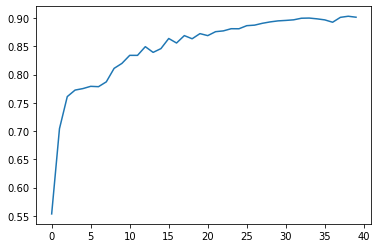

In [47]:
epochs = [i for i in range(num_epochs)]

plt.figure()
plt.plot(epochs, performances)
plt.show()



## Test Basic Active Learning on this model

In [8]:
tester = Tester([x_main, x_secondary], y)
tester.INITIAL_TRAIN_DATA_FRACTION = 0.05
tester.ACTIVE_LEARNING_BATCH_SIZE = 256
tester.TRAINING_EPOCHS = 4
tester.TEST_REPEAT_COUNT = 2

Test 1: Data size 2512: : 100%|██████████| 10/10 [05:13<00:00, 31.31s/it, data_size=2512, test_acc=0.665, train_acc=0.651]


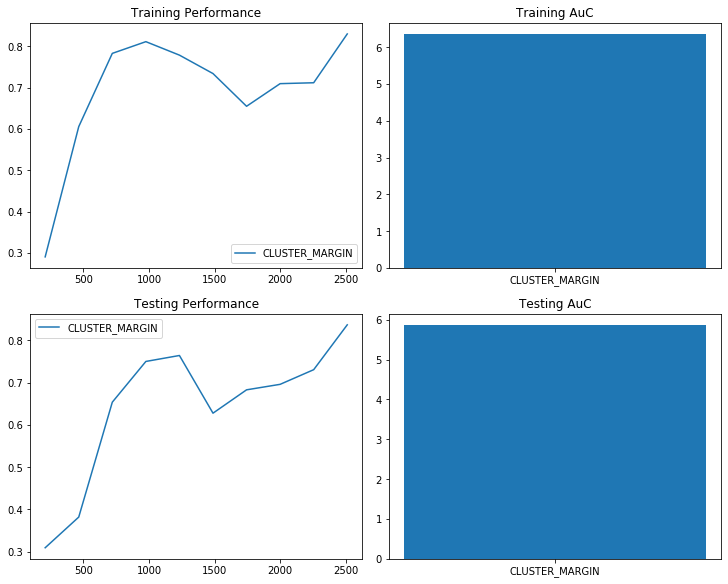

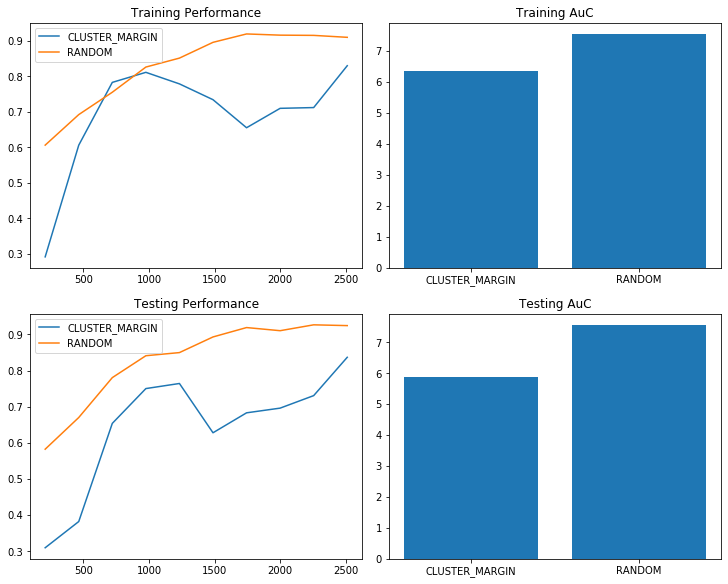

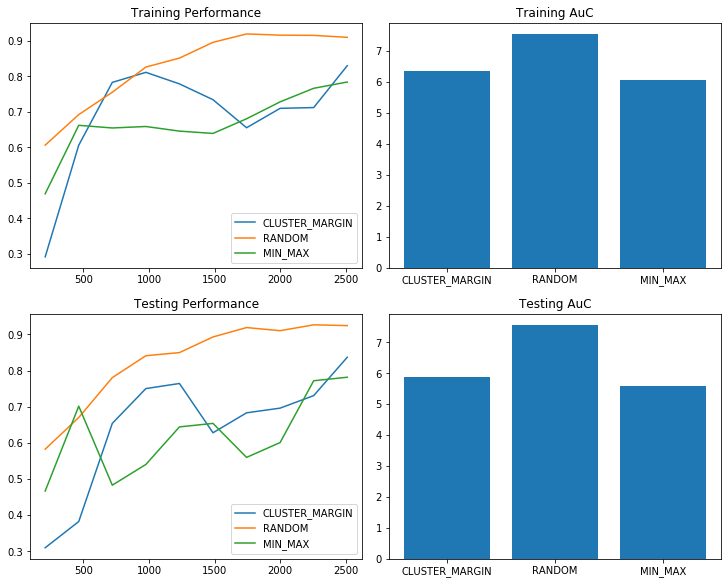

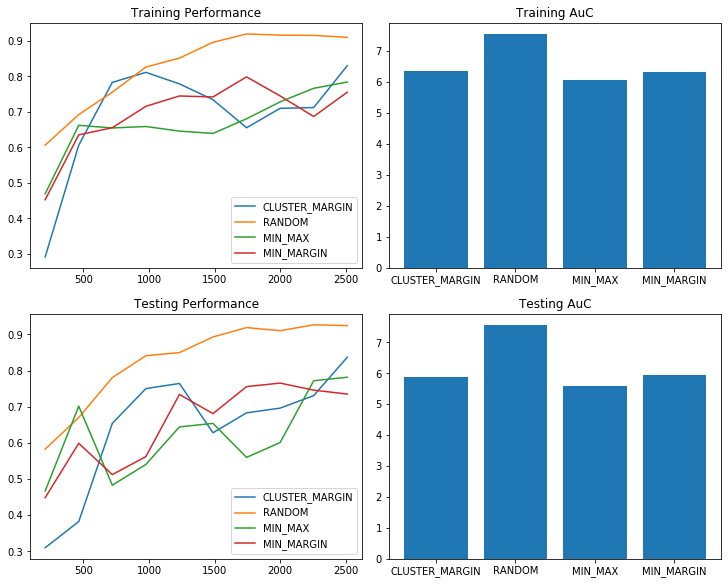

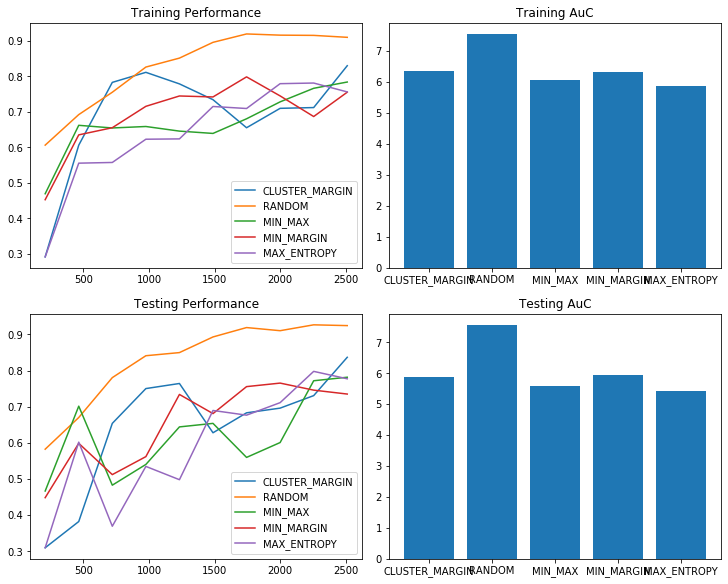

In [9]:
tester.test_model(MultiModalLateFusionModelInterface("CLUSTER_MARGIN", tester.ACTIVE_LEARNING_BATCH_SIZE))
tester.plot_results(plot_savename="test_2_results.png")
tester.test_model(MultiModalLateFusionModelInterface("RANDOM"))
tester.plot_results()
tester.test_model(MultiModalLateFusionModelInterface("MIN_MAX"))
tester.plot_results()
tester.test_model(MultiModalLateFusionModelInterface("MIN_MARGIN"))
tester.plot_results()
tester.test_model(MultiModalLateFusionModelInterface("MAX_ENTROPY"))
tester.plot_results()

## Investigating Gradient Embeddings

  0%|          | 0/10 [00:00<?, ?it/s]

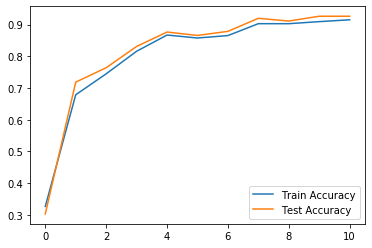

In [10]:
model_interface = MultiModalLateFusionModelInterface("CLUSTER_MARGIN")

# Train on some part of the data
labeled_size = round(0.9 * len(x_main))
x_main_labeled = x_main[:labeled_size]
x_secondary_labeled = x_secondary[:labeled_size]
y_labeled = y[:labeled_size]
x_main_unlabeled = x_main[labeled_size:]
x_secondary_unlabeled = x_secondary[labeled_size:]
y_unlabeled = y[labeled_size:]

# Log training as sanity check
train_accuracy_curve = []
test_accuracy_curve = []
train_acc = ACCURACY(y_labeled, model_interface.predict([x_main_labeled, x_secondary_labeled]))
test_acc = ACCURACY(y_unlabeled, model_interface.predict([x_main_unlabeled, x_secondary_unlabeled]))
train_accuracy_curve.append(train_acc)
test_accuracy_curve.append(test_acc)

epoch_count = 10
epoch_range = trange(epoch_count)
epoch_range.set_postfix(train_acc=train_acc, test_acc=test_acc)
for epoch in epoch_range:
    model_interface.train([x_main_labeled, x_secondary_labeled], y_labeled)

    train_acc = ACCURACY(y_labeled, model_interface.predict([x_main_labeled, x_secondary_labeled]))
    test_acc = ACCURACY(y_unlabeled, model_interface.predict([x_main_unlabeled, x_secondary_unlabeled]))
    train_accuracy_curve.append(train_acc)
    test_accuracy_curve.append(test_acc)

    epoch_range.set_postfix(train_acc=train_acc, test_acc=test_acc)

plt.plot(train_accuracy_curve, label="Train Accuracy")
plt.plot(test_accuracy_curve, label="Test Accuracy")
plt.legend()
plt.show()

In [11]:
embeddings_labeled, embedding_ind_to_param_ind = compute_gradient_embeddings(model_interface.model, [model_interface.model.post_fusion_layer.weight], [x_main_labeled, x_secondary_labeled])

In [14]:
# get the gradient embeddings for the two 
print(embeddings_labeled.shape)
print(embedding_ind_to_param_ind)

(4162, 256)
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 0, 9], [0, 0, 10], [0, 0, 11], [0, 0, 12], [0, 0, 13], [0, 0, 14], [0, 0, 15], [0, 0, 16], [0, 0, 17], [0, 0, 18], [0, 0, 19], [0, 0, 20], [0, 0, 21], [0, 0, 22], [0, 0, 23], [0, 0, 24], [0, 0, 25], [0, 0, 26], [0, 0, 27], [0, 0, 28], [0, 0, 29], [0, 0, 30], [0, 0, 31], [0, 0, 32], [0, 0, 33], [0, 0, 34], [0, 0, 35], [0, 0, 36], [0, 0, 37], [0, 0, 38], [0, 0, 39], [0, 0, 40], [0, 0, 41], [0, 0, 42], [0, 0, 43], [0, 0, 44], [0, 0, 45], [0, 0, 46], [0, 0, 47], [0, 0, 48], [0, 0, 49], [0, 0, 50], [0, 0, 51], [0, 0, 52], [0, 0, 53], [0, 0, 54], [0, 0, 55], [0, 0, 56], [0, 0, 57], [0, 0, 58], [0, 0, 59], [0, 0, 60], [0, 0, 61], [0, 0, 62], [0, 0, 63], [0, 1, 0], [0, 1, 1], [0, 1, 2], [0, 1, 3], [0, 1, 4], [0, 1, 5], [0, 1, 6], [0, 1, 7], [0, 1, 8], [0, 1, 9], [0, 1, 10], [0, 1, 11], [0, 1, 12], [0, 1, 13], [0, 1, 14], [0, 1, 15], [0, 1, 16], [0, 1, 17], [0, 1, 18], [0, 1, 19],

In [16]:
model_interface.model.post_fusion_layer.weight.shape

torch.Size([4, 64])

In [18]:
embedding_ind_to_param_ind = np.array(embedding_ind_to_param_ind)
first_modality_embeddings=None
#for i in range(embeddings_labeled.shape[0]):

np.unravel_index(np.arange(31), model_interface.model.post_fusion_layer.weight.shape)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]))

In [20]:
test = torch.rand((4,64))
test

tensor([[0.7560, 0.0786, 0.4153, 0.0480, 0.4294, 0.3445, 0.0961, 0.3409, 0.0284,
         0.9208, 0.0543, 0.9619, 0.7768, 0.5987, 0.6826, 0.6250, 0.1752, 0.9133,
         0.3529, 0.5023, 0.7328, 0.9471, 0.3438, 0.2217, 0.5303, 0.6467, 0.8911,
         0.7792, 0.8315, 0.0735, 0.4339, 0.2830, 0.0491, 0.9680, 0.8790, 0.1747,
         0.7181, 0.5479, 0.2866, 0.3374, 0.3439, 0.0388, 0.4281, 0.9844, 0.2667,
         0.0821, 0.2218, 0.9577, 0.6100, 0.5768, 0.8414, 0.8140, 0.2949, 0.2876,
         0.0263, 0.3976, 0.9141, 0.6250, 0.5181, 0.8677, 0.4046, 0.1058, 0.1224,
         0.8964],
        [0.6182, 0.6686, 0.4921, 0.7660, 0.0580, 0.2187, 0.4134, 0.0060, 0.9159,
         0.1074, 0.2609, 0.6649, 0.4430, 0.1460, 0.6818, 0.2334, 0.8237, 0.0179,
         0.4237, 0.9068, 0.8574, 0.9332, 0.2365, 0.1452, 0.3028, 0.3260, 0.4431,
         0.4569, 0.0188, 0.2803, 0.2246, 0.0712, 0.9670, 0.4286, 0.8368, 0.7727,
         0.6463, 0.9327, 0.3415, 0.0893, 0.6690, 0.0841, 0.9611, 0.7589, 0.2409,
         0

In [24]:
test[:, np.arange(31)]

tensor([[0.7560, 0.0786, 0.4153, 0.0480, 0.4294, 0.3445, 0.0961, 0.3409, 0.0284,
         0.9208, 0.0543, 0.9619, 0.7768, 0.5987, 0.6826, 0.6250, 0.1752, 0.9133,
         0.3529, 0.5023, 0.7328, 0.9471, 0.3438, 0.2217, 0.5303, 0.6467, 0.8911,
         0.7792, 0.8315, 0.0735, 0.4339],
        [0.6182, 0.6686, 0.4921, 0.7660, 0.0580, 0.2187, 0.4134, 0.0060, 0.9159,
         0.1074, 0.2609, 0.6649, 0.4430, 0.1460, 0.6818, 0.2334, 0.8237, 0.0179,
         0.4237, 0.9068, 0.8574, 0.9332, 0.2365, 0.1452, 0.3028, 0.3260, 0.4431,
         0.4569, 0.0188, 0.2803, 0.2246],
        [0.7951, 0.1576, 0.2982, 0.4517, 0.7303, 0.3118, 0.1872, 0.2519, 0.6303,
         0.2036, 0.6396, 0.3591, 0.9319, 0.6772, 0.8658, 0.0499, 0.5405, 0.4895,
         0.8659, 0.6550, 0.0873, 0.8274, 0.7525, 0.0630, 0.3761, 0.6132, 0.3391,
         0.2440, 0.0837, 0.0637, 0.7015],
        [0.9771, 0.1683, 0.8923, 0.8454, 0.5574, 0.0137, 0.7592, 0.4708, 0.5579,
         0.0671, 0.7088, 0.4981, 0.4769, 0.2657, 0.4458, 0.1280,

In [34]:
#test2 = np.concatenate((np.arange(4).reshape(-1,1), np.arange(31).reshape(-1,1)), axis=1)
#print(test2)
#np.ravel_multi_index(test2, (4,64))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 31

In [44]:
first_modality_index_combinations = np.array(np.meshgrid(np.arange(3),np.arange(31))).T.reshape(-1,2)
second_modality_index_combinations = np.array(np.meshgrid(np.arange(4),np.arange(32)+31)).T.reshape(-1,2)
#print(second_modality_index_combinations)
#print(first_modality_index_combinations.shape)
#np.ravel_multi_index(first_modality_index_combinations, (4,64))
print(first_modality_index_combinations)

[[ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 0 15]
 [ 0 16]
 [ 0 17]
 [ 0 18]
 [ 0 19]
 [ 0 20]
 [ 0 21]
 [ 0 22]
 [ 0 23]
 [ 0 24]
 [ 0 25]
 [ 0 26]
 [ 0 27]
 [ 0 28]
 [ 0 29]
 [ 0 30]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1  8]
 [ 1  9]
 [ 1 10]
 [ 1 11]
 [ 1 12]
 [ 1 13]
 [ 1 14]
 [ 1 15]
 [ 1 16]
 [ 1 17]
 [ 1 18]
 [ 1 19]
 [ 1 20]
 [ 1 21]
 [ 1 22]
 [ 1 23]
 [ 1 24]
 [ 1 25]
 [ 1 26]
 [ 1 27]
 [ 1 28]
 [ 1 29]
 [ 1 30]
 [ 2  0]
 [ 2  1]
 [ 2  2]
 [ 2  3]
 [ 2  4]
 [ 2  5]
 [ 2  6]
 [ 2  7]
 [ 2  8]
 [ 2  9]
 [ 2 10]
 [ 2 11]
 [ 2 12]
 [ 2 13]
 [ 2 14]
 [ 2 15]
 [ 2 16]
 [ 2 17]
 [ 2 18]
 [ 2 19]
 [ 2 20]
 [ 2 21]
 [ 2 22]
 [ 2 23]
 [ 2 24]
 [ 2 25]
 [ 2 26]
 [ 2 27]
 [ 2 28]
 [ 2 29]
 [ 2 30]]
